In [1]:
import os
import ee
import datetime
import time
import sklearn

import geopandas as gp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from dateutil.relativedelta import relativedelta
from sklearn import preprocessing
from shapely.ops import unary_union
from pandas.plotting import register_matplotlib_converters
from sklearn import preprocessing
from shapely.ops import unary_union
from pandas.tseries.offsets import MonthEnd

register_matplotlib_converters()
ee.Initialize()

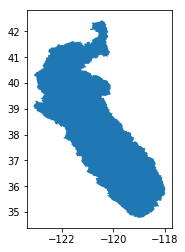

In [3]:
'''
Set the init params:
1) Area: Read from Shapefile
2) Years to analyze: Supplied
3) Scale (optional): Resolution at which to perform analysis
4) Satellites / datasets: Queried from Earth Engine
'''

##### AREA #####

# HUC 4s draining to the CV 
cv = gp.read_file("../shape/HU4_merged.shp")
cv2 = cv.geometry.simplify(0.1)
lls = cv2.geometry.iloc[0]
x,y = lls.exterior.coords.xy
coords = [list(zip(x,y))]
area = ee.Geometry.Polygon(coords)
sa_km3 = round(cv2.area[0] * 10000, 2)
        
##### TIME RANGE #####
years = [x for x in range(2001, 2018)]
months = range(1,13)

##### SCALE #####
cv.plot()

In [4]:
# This dictionary contains the ImageCollection objects, variable names, and scaling factors to convert units to km^3 / month. See individual links for more info

data = {}


###################
##### ET data #####
###################

# https://developers.google.com/earth-engine/datasets/catalog/MODIS_006_MOD16A2
data['modis_aet'] = [ee.ImageCollection('MODIS/006/MOD16A2'), "ET", 0.1]
data['modis_pet'] = [ee.ImageCollection('MODIS/006/MOD16A2'), "PET", 0.1]

# https://developers.google.com/earth-engine/datasets/catalog/IDAHO_EPSCOR_TERRACLIMATE
data['tc_aet'] = [ee.ImageCollection('IDAHO_EPSCOR/TERRACLIMATE'), "aet", 0.1]
data['tc_pet'] = [ee.ImageCollection('IDAHO_EPSCOR/TERRACLIMATE'), "pet", 0.1]

# https://developers.google.com/earth-engine/datasets/catalog/IDAHO_EPSCOR_GRIDMET
data['gmet_etr'] = [ee.ImageCollection('IDAHO_EPSCOR/GRIDMET'), "etr", 1]
data['gmet_eto'] = [ee.ImageCollection('IDAHO_EPSCOR/GRIDMET'), "eto", 1]

# https://developers.google.com/earth-engine/datasets/catalog/NASA_FLDAS_NOAH01_C_GL_M_V001
data['fldas'] = [ee.ImageCollection('NASA/FLDAS/NOAH01/C/GL/M/V001'), "Evap_tavg", 86400*30]

# https://developers.google.com/earth-engine/datasets/catalog/MODIS_NTSG_MOD16A2_105 (Only current to 2015)
data['modis_aet2'] = [ee.ImageCollection("MODIS/NTSG/MOD16A2/105"), "ET", 0.1]
data['modis_pet2'] = [ee.ImageCollection("MODIS/NTSG/MOD16A2/105"), "PET", 0.1]

# https://developers.google.com/earth-engine/datasets/catalog/NASA_GLDAS_V020_NOAH_G025_T3H
# The Evaporation rate is instantaneous (i.e. W/km^2/second). There are 86400 seconds in a day, 30 days in a month. A GLDAS month yields 240 images at 3-hourly temporal model resolution 
data['gldas'] = [ee.ImageCollection('NASA/GLDAS/V021/NOAH/G025/T3H'), 'Evap_tavg', 86400*30 / 240] 
data['gldas_eto'] = [ee.ImageCollection('NASA/GLDAS/V021/NOAH/G025/T3H'), 'PotEvap_tavg', 1 / 240] 

# https://developers.google.com/earth-engine/datasets/catalog/NASA_NLDAS_FORA0125_H002
data['nldas'] = [ee.ImageCollection('NASA/NLDAS/FORA0125_H002'), 'potential_evaporation', 1]

###################
##### P data ######
###################

data['trmm']  =  [ee.ImageCollection('TRMM/3B43V7'), "precipitation", 720]
data['prism'] = [ee.ImageCollection("OREGONSTATE/PRISM/AN81m"), "ppt", 1]
data['chirps'] = [ee.ImageCollection('UCSB-CHG/CHIRPS/PENTAD'), "precipitation", 1]
data['persia'] = [ee.ImageCollection("NOAA/PERSIANN-CDR"), "precipitation", 1]

# https://developers.google.com/earth-engine/datasets/catalog/NASA_ORNL_DAYMET_V3
data['dmet'] = [ee.ImageCollection('NASA/ORNL/DAYMET_V3'), "prcp", 1]

###################
##### SWE data #####
####################
data['swe'] = [ee.ImageCollection('NASA/FLDAS/NOAH01/C/GL/M/V001'), "SWE_inst", 1 ]
data['gldas_swe'] = [ee.ImageCollection('NASA/GLDAS/V021/NOAH/G025/T3H'), "SWE_inst", 1 / 240 ]
data['dmet_swe'] = [ee.ImageCollection('NASA/ORNL/DAYMET_V3'), "swe", 1/240]

####################
##### DS data ######
####################
data['grace'] = [ee.ImageCollection('NASA/GRACE/MASS_GRIDS/LAND'), "lwe_thickness_jpl", 1]

####################
##### R data #######
####################
data['r'] = [ee.ImageCollection('IDAHO_EPSCOR/TERRACLIMATE'), "ro", 1]
data['runoff'] = [ee.ImageCollection("NASA/FLDAS/NOAH01/C/GL/M/V001"), "Qs_tavg", 86400*24]

# GLDAS
data['ssr'] = [ee.ImageCollection('NASA/GLDAS/V021/NOAH/G025/T3H'), "Qs_acc", 1]
data['bfr'] = [ee.ImageCollection('NASA/GLDAS/V021/NOAH/G025/T3H'), "Qsb_acc", 1]
data['qsm'] = [ee.ImageCollection('NASA/GLDAS/V021/NOAH/G025/T3H'), "Qsm_acc", 1]

#####################
##### SM data #######
#####################

data['sm'] = [ee.ImageCollection('IDAHO_EPSCOR/TERRACLIMATE'), "soil", 0.1]
data['gldas_sm'] = [ee.ImageCollection('NASA/GLDAS/V021/NOAH/G025/T3H'), "RootMoist_inst", 1 / 240]

data['sm1'] = [ee.ImageCollection("NASA/FLDAS/NOAH01/C/GL/M/V001"), "SoilMoi00_10cm_tavg", 1 ]
data['sm2'] = [ee.ImageCollection("NASA/FLDAS/NOAH01/C/GL/M/V001"), "SoilMoi10_40cm_tavg", 1 ]
data['sm3'] = [ee.ImageCollection("NASA/FLDAS/NOAH01/C/GL/M/V001"), "SoilMoi40_100cm_tavg", 1 ]
data['sm4'] = [ee.ImageCollection("NASA/FLDAS/NOAH01/C/GL/M/V001"), "SoilMoi100_200cm_tavg", 1 ]


data['gsm1'] = [ee.ImageCollection("NASA/GLDAS/V021/NOAH/G025/T3H"), "SoilMoi0_10cm_inst", 1/240 ]
data['gsm2'] = [ee.ImageCollection("NASA/GLDAS/V021/NOAH/G025/T3H"), "SoilMoi10_40cm_inst", 1/240 ]
data['gsm3'] = [ee.ImageCollection("NASA/GLDAS/V021/NOAH/G025/T3H"), "SoilMoi40_100cm_inst", 1/240 ]
data['gsm4'] = [ee.ImageCollection("NASA/GLDAS/V021/NOAH/G025/T3H"), "SoilMoi100_200cm_inst", 1/240 ]

In [5]:
def get_data(dataset, year, month, area):
    '''
    calculates the monthly sum a dataset in units of mm/time 
    '''

    col = dataset[0]
    var = dataset[1]
    scaling_factor = dataset[2]

    t = col.filter(ee.Filter.calendarRange(year, year, 'year')).filter(ee.Filter.calendarRange(month, month, 'month')).select(var).filterBounds(area).sum()
    t2 = t.multiply(1e-3).multiply(ee.Image.pixelArea()).multiply(scaling_factor).multiply(1e-9)
    # convert mm to m, multiply by pixel area (m^2), multiply by scaling factor, m^3 to km^3
    scale = t2.projection().nominalScale()
    sumdict  = t2.reduceRegion(
        reducer = ee.Reducer.sum(),
        geometry = area,
        scale = scale)
    
    result = sumdict.getInfo()[var]
    
    return result

def wrapper(dataset):
    
    '''
    Wrapper for `get_data` that takes a dataset and an area
    '''
    monthly = []

    for year in years:
        print(year)
        for month in months:
            r = get_data(dataset, year, month, area)
            monthly.append(r)
            time.sleep(5)
    
    print("wrapper complete")
    return monthly

def gen_polys(geometry, dx=0.5, dy=0.5):
    
    '''
    Return ee.ImaceCollection of polygons used to submit full res queries
    '''
    
    bounds = ee.Geometry(geometry).bounds()
    coords = ee.List(bounds.coordinates().get(0))
    ll = ee.List(coords.get(0))
    ur = ee.List(coords.get(2))
    xmin = ll.get(0)
    xmax = ur.get(0)
    ymin = ll.get(1)
    ymax = ur.get(1)

    latlist = ee.List.sequence(ymin, ymax, dx)
    lonlist = ee.List.sequence(xmin, xmax, dy)
    
    polys = []
    
    for lon in lonlist.getInfo():
        for lat in latlist.getInfo():
        
            def make_rect(lat, lon):
                lattemp = ee.Number(lat)
                lontemp = ee.Number(lon)
                uplattemp = lattemp.add(dy)
                lowlontemp = lontemp.add(dx)

                return ee.Feature(ee.Geometry.Polygon([[lontemp, lattemp],[lowlontemp, lattemp],[lowlontemp, uplattemp],[lontemp, uplattemp]]))
            
            poly = make_rect(lat,lon)
            polys.append(poly)
    
    return ee.FeatureCollection(ee.List(polys))

def chunk(dataset,area):
    '''
    This doesnt work yet as expected. This sums the variable in each chunk to give a pseudospatial respresentation 
    '''
    polys = gen_polys(area)
    d = polys.getInfo()
    results = []
    for i in d['features']:
        aoi = ee.Geometry.Polygon(i['geometry']['coordinates']).intersection(area)
        t = col.filter(ee.Filter.calendarRange(year, year, 'year')).filter(ee.Filter.calendarRange(month, month, 'month')).select(var).filterBounds(aoi).sum()
        t2 = t.multiply(1e-3).multiply(ee.Image.pixelArea()).multiply(scaling_factor).multiply(1e-9)

        scale = t2.projection().nominalScale()
        sumdict  = t2.reduceRegion(
            reducer = ee.Reducer.sum(),
            geometry = aoi,
            scale = scale)

        result = sumdict.getInfo()[var]
        results.append(result)
        print('poly complete')
        
    return results

def calc_monthly_sum(dataset, years, months):
    
    '''
    Calculates monthly sum for hourly data. works for GLDAS / NLDAS 
    '''
    ImageCollection = dataset[0]
    var = dataset[1]
    scaling_factor = dataset[2]
            
    period_start = datetime.datetime(years[0], 1, 1)
    start_date = period_start.strftime("%Y-%m-%d")
    period_end = datetime.datetime(years[-1]+1, 1, 1)
    dt_idx = pd.date_range(period_start,period_end, freq='M')
    
    sums = []
    seq = ee.List.sequence(0, len(dt_idx))
    
    for i in seq.getInfo():
        start = ee.Date(start_date).advance(i, 'month')
        end = start.advance(1, 'month');
        im = ee.ImageCollection(ImageCollection).select(var).filterDate(start, end).sum().set('system:time_start', start.millis())
        ic = im.multiply(1e-3).multiply(ee.Image.pixelArea()).multiply(scaling_factor).multiply(1e-9)
        scale = ic.projection().nominalScale()
        
        sumdict  = ic.reduceRegion(
            reducer = ee.Reducer.sum(),
            geometry = area,
            scale = scale)
        total = sumdict.getInfo()[var]
        print(total)
        sums.append(total)

    return sums


In [6]:
years = range(2001, 2019)
months = range(1,13)
start = datetime.datetime(years[0], 1, 1)
end = datetime.datetime(years[-1]+1, 1, 1)
dt_idx = pd.date_range(start,end, freq='M')

In [8]:
# ET
fldas_aet = wrapper(data['fldas'])
modis_pet = wrapper(data['modis_pet'])
modis_aet = wrapper(data['modis_aet'])

2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
wrapper complete
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
wrapper complete
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
wrapper complete


In [9]:
tc_aet = wrapper(data['tc_aet'])
tc_pet = wrapper(data['tc_pet'])

2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
wrapper complete
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
wrapper complete


In [11]:
eto_g = wrapper(data['gmet_eto'])
etr_g = wrapper(data['gmet_etr'])

2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
wrapper complete
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
wrapper complete


In [13]:
# GLDAS / NLDAS ET
et_g = calc_monthly_sum(data['gldas'], years, months)
print("done")
et_n = calc_monthly_sum(data['nldas'], years, months)
print("done")
gldas_eto = calc_monthly_sum(data['gldas_eto'], years, months)

2.553392852346504
3.6566156852017975
7.880228694038021
10.616467201027534
14.09111851926019
9.32771317357755
6.279169930503878
3.12686923697799
2.027855252109454
1.6934750095775208
2.2576204156669335
1.8046940999009906
2.566693070861223
4.3223341930072285
7.880928848649427
10.025449895285817
11.635436732960878
10.422297212899498
6.477562097695226
2.9715391104958178
1.411206162217509
0.7003934031906875
3.058671984605266
2.641916497186952
3.4275448071656345
4.697040103564716
9.019781202178175
9.689197996319487
14.7160145259047
12.771612198164702
8.359470546911725
5.359972571902766
2.640244456241013
1.217766088516667
1.5598230943588922
2.371164272159084
2.6604539994344893
3.8333093229753037
10.58777004431901
11.578113483385527
10.55097581580168
8.962553050627633
5.791283503632974
2.9346840466953803
1.5394247499564553
2.3418439671480114
3.5011496745093162
2.7010474251626713
2.8128812071201144
4.4298524010139175
9.21729591707114
12.494802670315192
15.138384031290009
14.1301583172236
12.2646

KeyboardInterrupt: 

In [14]:
gldas_eto = calc_monthly_sum(data['gldas_eto'], years, months)

6.093209464921782
6.8074883875828816
16.661255337488072
25.981846410248288
54.99802940735997
58.503256366633316
56.415856713786404
56.880687405698474
43.590865208340325
33.68643718201375
10.809868878587363
4.157083531937076
6.318250866170325
10.39158720781715
18.94005814998823
30.471580016972915
45.68738405762537
60.37071728057497
63.36865599220478
57.91173041422707
46.5103949858125
32.69471837322294
16.583732079448776
6.591813841004955
8.52391192494399
12.041339619965811
21.58684992487156
21.68362732657249
43.24502351327243
59.30161422813482
64.20585500975642
54.59093624480248
47.43981578133832
36.82503583514562
11.940107694274225
5.890495765211025
6.070313690385383
7.985354862373276
25.124909237896162
38.45948111363365
49.4429067609858
58.57516226433413
60.440656636042824
54.2210655780368
45.3793942490603
24.27024113471771
11.752033535083111
7.830874286692571
5.029259126033284
8.527999181923072
18.5812539578536
28.12709389225401
37.091014818761515
47.335769447835816
60.96627467621586

In [15]:
# GLDAS SWE
gldas_swe = calc_monthly_sum(data['gldas_swe'], years, months)

1.4061638027391954
3.0153221037714406
3.374577479964915
0.6814650849305967
0.021982698716627832
0.0012868436678865097
0.002751131579363632
0.004120914892703966
0.005193022322747725
0.006525806089547499
0.27268654772873024
3.089563504795252
4.779351408035278
3.8371361959212207
2.1965645397553657
0.11256507101384287
0.026848439827811845
0.001422012112514011
0.0009780858374353104
0.0014107215997157915
0.0019394642358854172
0.010076580752229175
0.10755095978918312
1.8231373574534167
2.1567719633474582
0.7672294535018721
0.5306054900474163
0.44771746983192046
0.14311301694341882
0.0003492319451046531
3.926956754751554e-05
3.481165219793011e-05
0.00022202799729133252
0.0021899741479175206
0.14022338974043963
0.9252397965686211
3.214106202219517
3.2007227611305438
1.6360942961780924
0.05165555803273055
0.007497248456542234
0.0019115290391884172
0.0020748126752959057
0.0027939440474886654
0.0039090658514597506
0.21421515721761444
0.5728241239615316
0.9935765849736593
5.261154134680381
3.951651

In [28]:
# daymet swe
dmet_swe = wrapper(data['dmet_swe'])

2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
wrapper complete


In [16]:
# Fetch Soil Moisture and swe - warning: takes some time
sm = wrapper(data['sm'])
swe = wrapper(data['swe']) #fldas

2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
wrapper complete
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
wrapper complete


In [17]:
gldas_sm = calc_monthly_sum(data['gldas_sm'], years ,months)

37.34391265536634
40.45764475531696
52.19791965132826
49.10574055087028
41.745013544911494
30.11765378306584
24.765122886707932
20.67272250761677
18.393092242535477
18.914634537175512
24.579794024344594
39.52745169456432
51.55574180801022
45.99272216022261
53.399557510529746
47.70209342553974
41.808983869575385
31.54913288809825
24.56214360222709
20.19528004699473
17.743545258945726
17.64417226617857
23.172017075885556
37.4976280853785
52.09292660327476
48.295007893367575
53.604000510508136
53.639735086927466
51.33407286099178
36.21037465897831
27.2702982557352
22.881247868701283
19.80897269005523
19.11169933083145
20.08396591467009
35.2147033763189
47.82507501071647
49.62284479438212
54.55162221722612
45.283727999650736
37.74456100746612
29.18508862363606
23.483046474902604
19.663649655694527
17.56620689055868
21.21535764363012
31.521615600242388
39.7424849279852
53.97761941948279
51.96766582452965
59.497895977702804
57.470375111345376
57.33061078694471
45.832218207483436
35.437909171

In [18]:
nldsm1 = calc_monthly_sum(data['sm1'], years, months)

0.05220970826533918
0.05608251673263178
0.05487392128214263
0.04862207990774565
0.03683663534499751
0.02896989142356994
0.027706035898963546
0.02496836533772102
0.026834304405646433
0.029072881296357815
0.04682991585091092
0.056381100164359994
0.05632599893757911
0.054725828255349114
0.052980015800702995
0.04587415026702333
0.040893846139498306
0.032142983702340935
0.02712914233549032
0.024921777001285637
0.025703314218830136
0.027721347823580097
0.04135482896870535
0.05053855159192978
0.055510118748170766
0.05408564172448775
0.05280967358016643
0.05128419001029324
0.0461606005844142
0.033169732475235615
0.02754025832331321
0.027734878405430798
0.027937610448771886
0.026072980588500303
0.03933609911883113
0.05285531993764646
0.05692635124106485
0.05747147295530401
0.05185489724054898
0.04358312354337228
0.03572622781708839
0.03116546862394375
0.028000667766624784
0.02568824391436513
0.026500341931579727
0.0347281457327271
0.046964427382505995
0.05076276500689512
0.05892234104344332
0.0

In [19]:
gldsm1 = calc_monthly_sum(data['gsm1'], years, months)
gldsm2 = calc_monthly_sum(data['gsm2'], years, months)
gldsm3 = calc_monthly_sum(data['gsm3'], years, months)
gldsm4 = calc_monthly_sum(data['gsm4'], years, months)

4.717497723488351
4.706357437850194
4.921875779656799
4.1059238103247955
2.8254011471338027
1.9366738889254553
1.7740306263195276
1.433824271910328
1.4913166560437026
1.886367578297165
3.385652376005887
4.848905083161216
4.954105136059953
4.34568960686247
4.6300709318831785
3.478572967370367
2.966189990380795
2.060248671181651
1.5991421422988192
1.3577235288268394
1.2818882816979902
1.356982973682371
2.999087214112605
4.43074778412926
4.7780949369284755
4.138908105919753
4.438471947875334
4.356327256387028
3.774099919013522
2.224868148950071
1.6896226284456957
1.91998695484509
1.6522777918817713
1.48251149844358
2.3759817735687805
4.41457971087582
5.0551109955988425
4.850433761718428
4.4234453991250735
3.210225235866676
2.5276525881618115
1.9280193730813504
1.6113208601544828
1.4296141588338702
1.3866566253628168
2.5374385796585397
3.7647175428766557
4.361790844760585
5.366958982589009
4.708762146915601
4.848072786445078
4.346214223440657
4.20960350714288
3.0188124809723083
2.123330079

In [20]:
# runoff
r = wrapper(data['r'])

2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
wrapper complete


In [21]:
ssr = calc_monthly_sum(data['ssr'], years, months)

0.2185901544252772
0.5999623336338822
1.0392808538593379
0.2938567783602686
0.009683048009950465
0.002188344362699881
0.0007357459851520216
3.2591969527175584e-05
0.007074932726670467
0.02481658061759398
0.31334992435024656
0.95490207411964
0.5691847457724137
0.3003152071644354
0.5248542925833144
0.06448104836958017
0.021378311046778484
0.00022973806457714357
3.634478596852323e-05
5.361499443188204e-06
0.00015815144338273158
6.14810456488903e-05
0.19430806527507902
2.014489130803689
0.24767056941801344
0.25141124692287425
0.48073376064807
0.9786430884796922
0.17124866745934986
0.00014184213146439803
0.00044345945809119925
0.008105701641248964
0.00035359970782002407
0.00014034063349387297
0.271453722753505
0.6728966294157868
0.3222931470343726
2.137636020047656
0.21523887024536711
0.014555990895509976
0.013017143944922316
0.00026624428927378744
9.743326392139226e-05
0.0004542595896589109
0.0007284755106409632
0.37928232737138645
0.06787088286063132
1.2905836394189134
0.5214417272216303


In [24]:
bfr = calc_monthly_sum(data['bfr'], years, months)

0.5382650643445224
1.5376338883152119
3.5870817963767534
1.4787395404027992
0.703575793048389
0.3384972157531022
0.25460432830391977
0.19841537425392103
0.1603121966057656
0.14553911697574873
0.1790384772260703
1.6642115945885942
7.793669720990449
2.290311963542234
2.9703661320622556
2.071904229023591
0.6859009319378664
0.2953143800551895
0.20493426470460607
0.1627814107943279
0.1335581370476788
0.12087800260452866
0.14245064381004546
1.6282452602366604
5.65343633627624
3.397783181164992
3.1802582842173766
5.158150925251412
3.8345717182571746
0.5185334250593766
0.28932339542180624
0.21622171321012912
0.1726387019740594
0.14981388582528737
0.12820634948754556
0.7810324476868019
3.673338480496183
6.943557051783459
5.067337091255302
1.3700755537448592
0.5091807640678431
0.2700292509119136
0.20281079847891037
0.16507489234589576
0.1372256158214024
0.14383922650251016
0.23864008057726108
0.6519010337068546
5.167627668938154
4.7956580567243305
5.3206899366257305
5.2119440551839835
3.94892632

In [25]:
qsm = calc_monthly_sum(data['qsm'], years, months)

1.316908450608743
2.733875474098795
5.097160415347764
1.4970131568794627
0.10383150916469305
0.0014876998790729111
0.0005315523039638779
0.0002640509668509252
0.00265825574917134
0.007298578639386508
0.42729318721771037
2.8123430580647506
1.7654924230212832
3.1071527269584305
2.97681010251798
0.6469390190796946
0.0765753153055834
0.001060560525932026
7.089677963292318e-05
2.1261939498848847e-05
7.937149369692866e-05
0.0016737693749878284
0.29261978160921376
2.588811999529961
3.3488540823570383
0.7777297898653541
0.8563174909457003
1.4645534720271982
0.46530467168959333
2.5552060165131688e-05
3.5966264283095524e-05
6.159668963861885e-05
2.4003071518951928e-05
0.0010554849754649941
0.40083460879003163
1.576458581939445
3.106922513101459
2.766566240502378
3.7946797497600473
0.19592141883360942
0.007599774005864798
0.00039141746884688853
0.00019858206022937486
0.0005813288598980634
0.0013916676453484085
0.3898336751956807
0.5781949774566199
1.762038918869726
3.523283770826419
2.53011323102

In [26]:
rt = calc_monthly_sum(data['runoff'], years , months)

0.6138104552367151
1.0554328208044486
1.6083694500572792
1.0448176925473562
0.39853394604824877
0.02161930208578093
0.014512013573169025
0.003439922158814611
0.057249023021273035
0.1369052396883628
0.8862976147522031
1.8275936355600912
1.2339724909089198
1.088820528997746
1.634061599342513
1.0164470258371812
0.4002742096750983
0.07544123017318301
0.004387775760700522
0.0023843675188923038
0.007936322829966438
0.010255498594234283
0.9226661387627833
2.40342683082642
1.1056096978851042
0.9156908624531229
1.7557601633590638
2.576202227564776
1.4158523580845774
0.2727998482951233
0.024242424977426524
0.019152694737981618
0.013162310499053033
0.0022841471946011506
0.27806065894518794
1.6136665170241855
0.9053176190791977
3.689198570583292
1.318701133962118
0.5667896382059333
0.2961171048299558
0.02322474061187492
0.005039907835415913
0.007671786352867686
0.010851634124949149
0.904023164885559
0.45066473159800535
1.4018664904422207
1.7605311102377899
1.5930017299118309
3.4245801469062576
1.5

In [27]:
# Fetch all precip data - warning: takes very long
p_p = wrapper(data['prism'])
p_c = wrapper(data['chirps'])
p_n = wrapper(data['persia'])
p_t = wrapper(data['trmm'])
p_d = wrapper(data['dmet'])

2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
wrapper complete
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
wrapper complete
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
wrapper complete
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
wrapper complete
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
wrapper complete


In [30]:
# Stack P datasets and calc mean
p_arrs = [np.array(x) for x in [p_p, p_c, p_n, p_t, p_d]]
p_stacked = np.column_stack(p_arrs)
p = np.mean(p_stacked, axis = 1)

# Stack ET Datasets, calc mean

# Actual ET (fldas, gldas, modis, terraclimate)
aet = [np.array(x) for x in [fldas_aet,  et_g[:-1], modis_aet, tc_aet]]
aet_s = np.column_stack(aet)
aet_m = np.mean(aet_s, axis = 1)

# Potential ET (nldas, gldas, gridmet eto, gridmet etr, modis, terraclimate)
pet = [np.array(x) for x in [et_n[:-1], gldas_eto[:-1], eto_g, etr_g, modis_pet, tc_pet]]
pet_s = np.column_stack(pet)
pet_m = np.mean(pet_s, axis = 1)

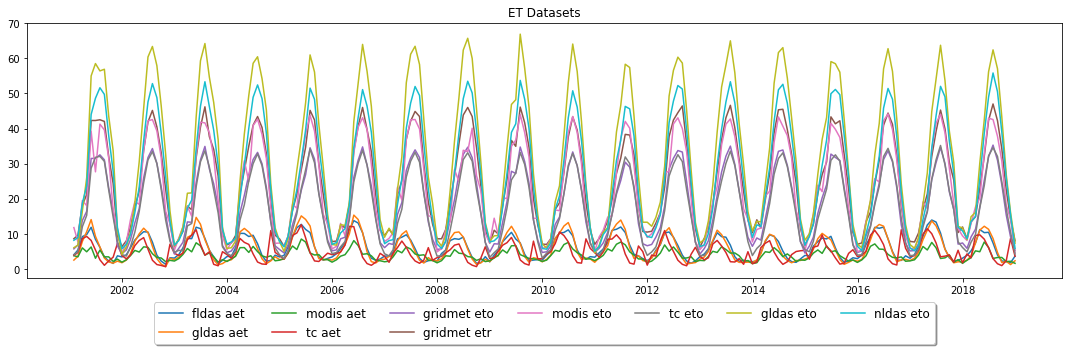

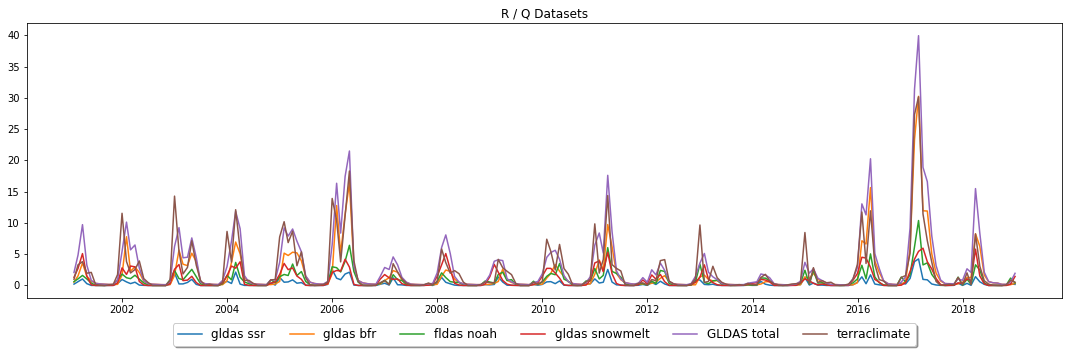

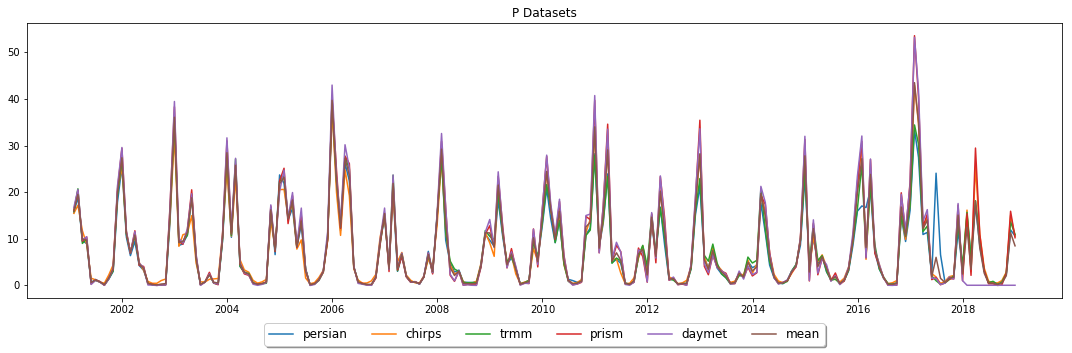

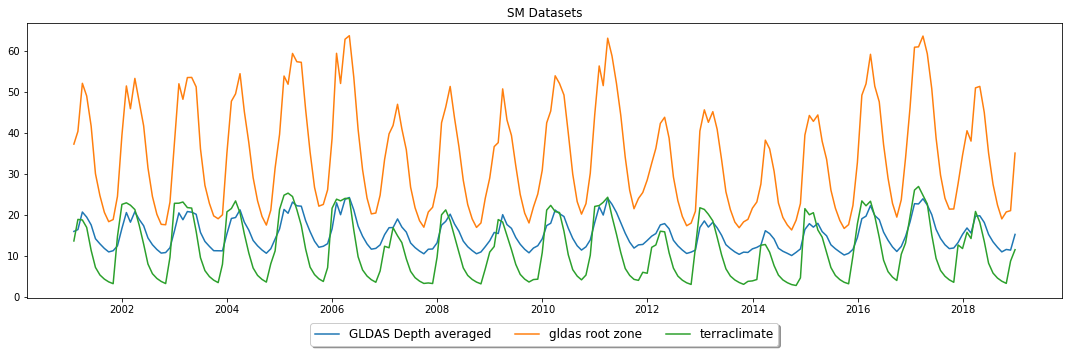

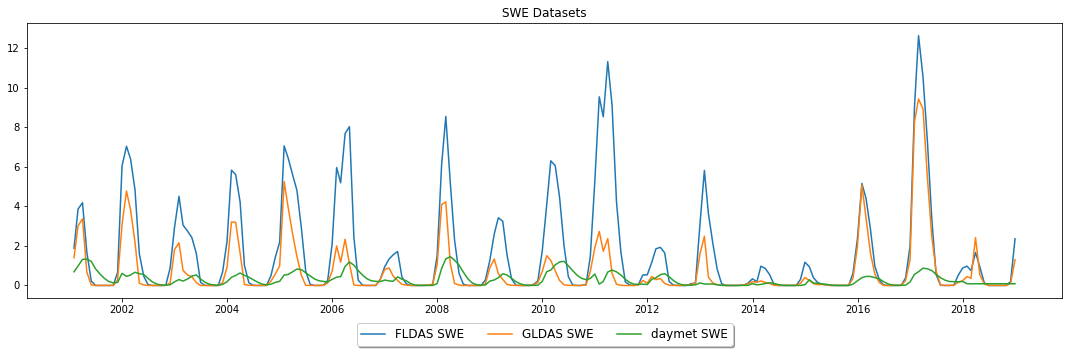

In [37]:
# Plot

plt.figure(figsize = (15,5))
plt.title("ET Datasets")

# AET
plt.plot(dt_idx, fldas_aet, label = 'fldas aet')
plt.plot(dt_idx, et_g[:-1], label = "gldas aet")
plt.plot(dt_idx, modis_aet, label = "modis aet")
plt.plot(dt_idx, tc_aet, label = "tc aet")

# PET
plt.plot(dt_idx, eto_g, label = 'gridmet eto')
plt.plot(dt_idx, etr_g, label = 'gridmet etr')
plt.plot(dt_idx, modis_pet, label = 'modis eto')
plt.plot(dt_idx, tc_pet, label = 'tc eto')
plt.plot(dt_idx, gldas_eto[:-1], label = 'gldas eto')
plt.plot(dt_idx, et_n[:-1], label = 'nldas eto')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.07), fancybox=True, shadow=True, ncol=7, prop = {"size":12})
plt.tight_layout()
plt.show()

# Q/R
plt.figure(figsize = (15,5))
plt.title("R / Q Datasets")
plt.plot(dt_idx, ssr[:-1], label = "gldas ssr")
plt.plot(dt_idx, bfr[:-1], label = 'gldas bfr')
plt.plot(dt_idx, rt[:-1], label = "fldas noah")
plt.plot(dt_idx, qsm[:-1], label = "gldas snowmelt")
plt.plot(dt_idx, np.column_stack(np.array(x) for x in [bfr[:-1],ssr[:-1],qsm[:-1]]).sum(axis=1), label = "GLDAS total")
plt.plot(dt_idx, r, label = "terraclimate")
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.07), fancybox=True, shadow=True, ncol=7, prop = {"size":12})
plt.tight_layout()
plt.show()

# P 
plt.figure(figsize = (15,5))
plt.title("P Datasets")
plt.plot(dt_idx, p_n, label = 'persian')
plt.plot(dt_idx, p_c, label = "chirps")
plt.plot(dt_idx, p_t, label = 'trmm')
plt.plot(dt_idx, p_p, label = 'prism')
plt.plot(dt_idx, p_d, label = 'daymet')
plt.plot(dt_idx, p, label = 'mean')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.07), fancybox=True, shadow=True, ncol=7, prop = {"size":12})
plt.tight_layout()
plt.show()

# SM
plt.figure(figsize = (15,5))
plt.title("SM Datasets")
plt.plot(dt_idx, np.column_stack(np.array(x) for x in [gldsm1[:-1],gldsm2[:-1],gldsm3[:-1], gldsm4[:-1]]).mean(axis=1) , label = "GLDAS Depth averaged")
plt.plot(dt_idx, gldas_sm[:-1], label = "gldas root zone")
plt.plot(dt_idx, sm, label = 'terraclimate')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.07), fancybox=True, shadow=True, ncol=7, prop = {"size":12})
plt.tight_layout()
plt.show()

# SWE
plt.figure(figsize = (15,5))
plt.title("SWE Datasets")
plt.plot(dt_idx, swe, label = "FLDAS SWE")
plt.plot(dt_idx, gldas_swe[:-1], label = "GLDAS SWE")
plt.plot(dt_idx, np.array(dmet_swe) / 240, label = "daymet SWE")

plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.07), fancybox=True, shadow=True, ncol=7, prop = {"size":12})
plt.tight_layout()
plt.show()


In [38]:
# Read c2vsim storage data
ds = pd.read_csv('../data/storage_cv.txt', sep='\t', header=0)
ds.set_index(ds['dt'], inplace = True)

# convert to datetime
ds.index = pd.to_datetime(ds.index)

# remove local timezone
ds = ds.tz_localize(None).copy()
ds.drop(["dt", "region"],axis = 1, inplace = True)
ds['s'] = ds['s'] * 1.23348 # MAF to km^3

# Read USGS Reservoir data
res_s = pd.read_csv("../data/reservoir_storage_ssjt.csv")
res_s.set_index(res_s.columns[0], inplace = True)
res_s.index = pd.to_datetime(res_s.index)
res_s.index.name = "date"
res_s.columns = ["res_s"]

# Read Streamflow IN data (Note that CA Aqueduct is accounted for here)
Qs_in = pd.read_csv("../data/Qs_in_monthly.csv", header = None)
Qs_in.set_index(Qs_in.columns[0], inplace = True)
Qs_in.index = pd.to_datetime(Qs_in.index)
Qs_in.index.name = "date"
Qs_in.columns = ["q_in"]

# Read Streamflow Out data
Qs_out = pd.read_csv("../data/Qs_out_dayflow.csv", header = None)
Qs_out.set_index(Qs_out.columns[0], inplace = True)
Qs_out.index = pd.to_datetime(Qs_out.index)
Qs_out.index.name = "date"
Qs_out.columns = ["q_out"]

# Experiment: Calculate the true runoff as SSJT runoff - CV runoff
# ssjtr = pd.read_csv("../data/all_data_ssjt.csv")
# ssjtr.set_index(ssjtr.columns[0], inplace = True)
# ssjtr.index = pd.to_datetime(ssjtr.index)
# ssjtr.index.name = "date"
# cvr = np.array(ssjtr.runoff.dropna() - r)

In [42]:
# Make a df from all the data

# Dict for each variable
d_aet = {"fldas_aet": fldas_aet,  "gldas_aet":et_g[:-1], "modis_aet":modis_aet, "tc_aet": tc_aet}
d_pet = {"nldas_etr": et_n[:-1], "gldas_etr": gldas_eto[:-1], "gmet_eto": eto_g, "gmet_etr": etr_g, "modis_pet": modis_pet, "tc_pet":tc_pet}
d_r = {"gldas_ssr":ssr[:-1] , "gldas_bfr": bfr[:-1], "gldas_qsm": qsm[:-1],
       "gldas":np.column_stack(np.array(x) for x in [bfr[:-1],ssr[:-1],qsm[:-1]]).sum(axis=1), 
       "fldas_r": rt[:-1], "tc_r": r}
d_p = {'p_prism': p_p, "p_chirps": p_c, "p_persiann": p_n,"p_trmm": p_t, "p_daymet": p_d}
d_swe = {"fldas_swe": swe, "gldas_swe": gldas_swe[:-1], "dmet_swet":dmet_swe}
d_sm = {"gldas_sm": gldas_sm[:-1], "tc_sm": sm, "gldas_m": np.column_stack(np.array(x) for x in [gldsm1[:-1],gldsm2[:-1],gldsm3[:-1], gldsm4[:-1]]).mean(axis=1)}

# Listo of all the values which are the timeseries for each var
alldat = [item for sublist in [d_aet.values(), d_pet.values(), d_r.values(), d_p.values(), d_swe.values(), d_sm.values()] for item in sublist]

# Make the df
alldata = pd.DataFrame(alldat).T
alldata.index = dt_idx
col_headers = [item for sublist in [d_aet.keys(), d_pet.keys(), d_r.keys(), d_p.keys(), d_swe.keys(), d_sm.keys()] for item in sublist]
alldata.columns = col_headers

# Merge with res storage and streamflow in / out 
df_t1 = pd.merge(alldata,Qs_in, how='inner', left_index=True, right_index=True)
df_t2 = pd.merge(df_t1,Qs_out, how='inner', left_index=True, right_index=True)
df = pd.merge(df_t2,res_s, how='inner', left_index=True, right_index=True)

# Verify
df.head()

# Save
# df.to_csv("../data/RS_DAT_FIN_monthly_2001_2018_CVWshed.csv")

,fldas_aet,gldas_aet,modis_aet,tc_aet,nldas_etr,gldas_etr,gmet_eto,modis_pet,tc_pet,gldas_ssr,...,p_daymet,fldas_swe,gldas_swe,dmet_swet,gldas_sm,tc_sm,gldas_m,q_in,q_out,res_s
2001-01-31,4.076607,2.553393,3.803094,3.917899,8.197657,6.093209,8.655086,11.809674,4.076570,0.218590,...,16.751653,1.881126,1.406164,166.339467,37.343913,13.683823,16.017710,0.763187,0.925951,1.267275
2001-02-28,5.418444,3.656616,3.491451,4.720649,8.973932,6.807488,9.629797,7.772501,4.970229,0.599962,...,20.561220,3.863002,3.015322,235.424183,40.457645,18.947571,16.460951,0.915681,0.934155,1.360578
2001-03-31,9.236698,7.880229,6.028299,8.669927,18.762289,16.661255,18.202018,19.518689,12.074108,1.039281,...,9.776323,4.190254,3.374577,316.701611,52.197920,18.812502,20.752214,1.097743,1.069754,1.511984
2001-04-30,9.832799,10.616467,4.924691,9.299260,23.643801,25.981846,21.208293,18.060522,15.294125,0.293857,...,10.435274,1.700627,0.681465,321.098065,49.105741,16.988080,19.509192,1.103427,1.397268,1.690033
2001-05-31,11.893000,14.091119,6.292865,8.151635,44.019606,54.998029,42.298768,39.228458,28.715317,0.009683,...,0.230130,0.224155,0.021983,292.185813,41.745014,11.386107,17.606792,1.396471,1.550421,1.738200


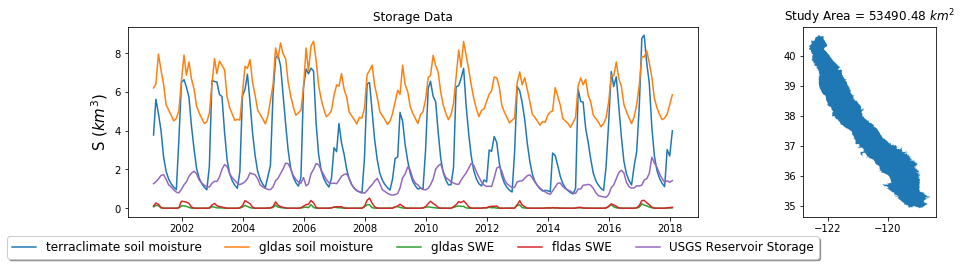

In [218]:
# SM data

f, (a0, a1) = plt.subplots(1,2, gridspec_kw = {'width_ratios':[3, 1]}, figsize=(15,3.5))

a0.set_title("Storage Data")

a0.plot(df.index, df.tc_sm, label = 'terraclimate soil moisture')
a0.plot(df.index, df.gldas_m, label = 'gldas soil moisture')
a0.plot(df.index, df.gldas_swe, label = 'gldas SWE')
a0.plot(df.index, df.fldas_swe, label = 'fldas SWE')
a0.plot(df.index, df.res_s, label = 'USGS Reservoir Storage')

a0.set_ylabel('S $(km^3)$', size = 15)
a0.legend(loc='upper center', bbox_to_anchor=(0.5, -0.07), fancybox=True, shadow=True, ncol=7, prop = {"size":12})

a1.set_title("Study Area = {} $km^2$".format(round(sa_km3, 3)))
cv.plot(ax=a1)

plt.show()

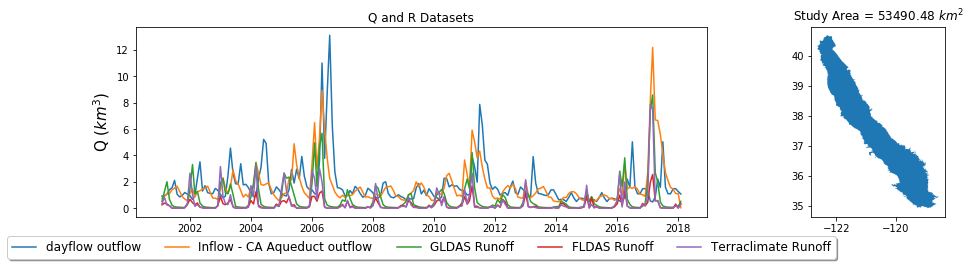

In [221]:
# Q and R data

f, (a0, a1) = plt.subplots(1,2, gridspec_kw = {'width_ratios':[3, 1]}, figsize=(15,3.5))

a0.set_title("Q and R Datasets")

a0.plot(df.index, df.q_out, label = 'dayflow outflow')
a0.plot(df.index, df.q_in, label = 'Inflow - CA Aqueduct outflow')
a0.plot(df.index, df.gldas, label = 'GLDAS Runoff')
a0.plot(df.index, df.fldas_r, label = 'FLDAS Runoff')
a0.plot(df.index, df.tc_r, label = 'Terraclimate Runoff')


a0.set_ylabel('Q $(km^3)$', size = 15)
a0.legend(loc='upper center', bbox_to_anchor=(0.5, -0.07), fancybox=True, shadow=True, ncol=7, prop = {"size":12})

a1.set_title("Study Area = {} $km^2$".format(round(sa_km3, 3)))
cv.plot(ax=a1)

plt.show()

In [237]:
# Apply the kc multiplier for ET0 data:

etdf = pd.read_csv("../data/et_kc.csv")
etdf = etdf.set_index(pd.to_datetime(etdf[etdf.columns[0]]))
etdf.drop(etdf.columns[0],axis = 1, inplace = True)

# Select the first year of scaling factors and apply this to the first 7 years of data
repeat_arr = etdf.et_multiplier[0:12]

# Merge with df
t = pd.merge(df, etdf,how = "outer", left_index = True, right_index = True)
t.drop(t.tail(12).index,inplace=True)

# Make 7 concats of the yearly dataframe, fill the nans in the cvdf with that
temp = pd.DataFrame(repeat_arr)
temp = pd.concat([temp]*7, ignore_index=True)
t.et_multiplier[t.et_multiplier.isna()] = temp[temp.columns[0]].values

/anaconda3/envs/gis/lib/python3.6/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


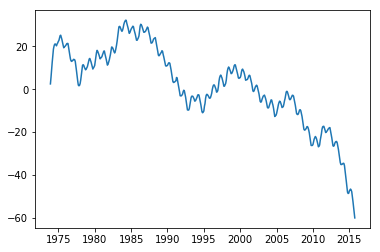

In [318]:
# Join the grace data, c2vsim data, wells to the df 

# Wells data (processed by zihan using Faunt 2009 SY values )
wells = pd.read_csv("../data/wells_ds_faunt_sy.csv")
wells.month = wells.month.astype(str)
wells.year = wells.year.astype(str)
wells.month = wells.month.str.zfill(2)
wells['Date'] = pd.to_datetime(wells.year + wells.month , format="%Y%m") + MonthEnd(1)
wells.index = wells.Date
wells.drop(['Date'], axis =1, inplace = True)
wells['ds_km3'] = wells[wells.columns[-1]] * 55000 * 1e-5

# Grace data
grace = pd.read_csv("../data/grace_argus.csv")
grace['dt'] = pd.to_datetime(grace[grace.columns[0]])
grace = grace.set_index(pd.to_datetime(grace[grace.columns[0]]))
grace.drop(["dt"],axis = 1, inplace = True)

# Subtract reservoir storage and soil moisture from grace 
grace['adj'] = grace.grace_mean[1:] - df.gldas_sm.diff()[1:] - df.res_s.diff()[1:] - df.fldas_swe.diff()[1:]
grace['adj'][0] = 0

# C2vsim
c2vsim = pd.read_csv("../data/storage_cv.txt", sep='\t', header=0)
c2vsim.set_index(c2vsim['dt'], inplace = True)

# convert to datetime
c2vsim.index = pd.to_datetime(c2vsim.index)
c2vsim.index = pd.to_datetime(c2vsim.index.strftime("%Y-%m-%d"))
c2vsim.drop(["dt", "region"],axis = 1, inplace = True)

plt.plot(np.cumsum(c2vsim.s.diff()[1:]))
plt.show()

In [239]:
# save the csv
# df.to_csv("../data/RS_DAT_FIN_monthly_2001_2018.csv")

print(list(df))

# Calc the balance
df['ds_rs'] = df.p_prism - df.gldas_aet - df.q_out + df.q_in - df.gldas_sm.diff() - df.res_s.diff()

# Chop off first 30 years of c2vsim and Initialize starting value as the c2vsim starting value
# df.ds[0] = df.s[0]

['fldas_aet', 'gldas_aet', 'modis_aet', 'tc_aet', 'nldas_etr', 'gldas_etr', 'gmet_eto', 'modis_pet', 'tc_pet', 'gldas_ssr', 'gldas_bfr', 'gldas_qsm', 'gldas', 'fldas_r', 'tc_r', 'p_prism', 'p_chirps', 'p_persiann', 'p_trmm', 'p_daymet', 'fldas_swe', 'gldas_swe', 'gldas_sm', 'tc_sm', 'gldas_m', 'q_in', 'q_out', 'res_s', 'ds']


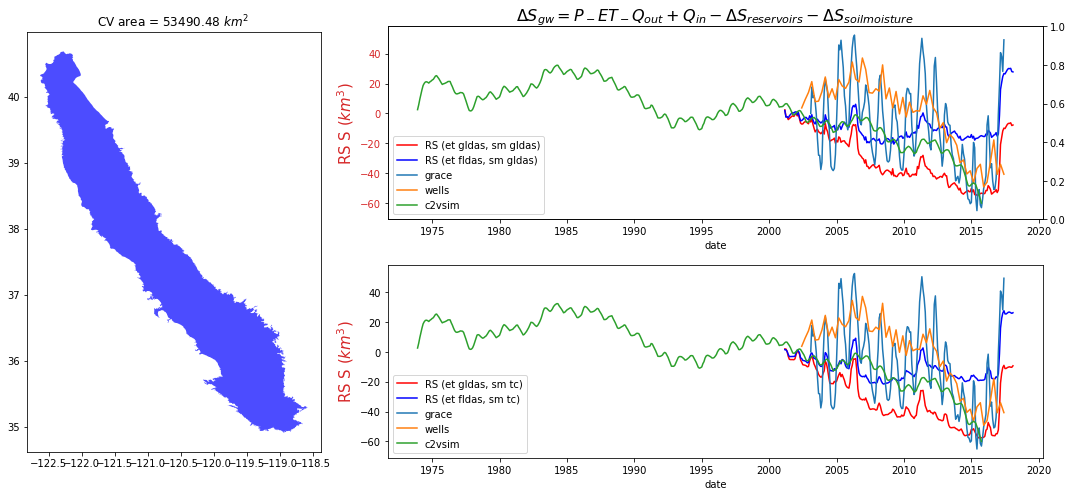

In [323]:
plt.figure(figsize=(15, 7))

G = gridspec.GridSpec(2, 3)

# Plot the basemaps
axes_1 = plt.subplot(G[:, 0])
cv.plot(ax=axes_1, color = "blue", alpha = 0.7)
axes_1.set_title("CV area = {} $km^2$ ".format(sa_km3))

# Top right timeseries
axes_2 = plt.subplot(G[0, 1:])
axes_2.set_title("$\Delta S_{gw} = P_ -  ET_ - Q_{out} + Q_{in} - \Delta S_{reservoirs} - \Delta S_{soil moisture}$", size = 16)

color = 'tab:red'
axes_2.set_xlabel('date')
axes_2.set_ylabel('RS S $(km^3)$', color=color, size = 15)
axes_2.plot(df.index, np.cumsum(df.p_prism - df.gldas_aet - df.q_out + df.q_in - df.gldas_sm.diff() - df.res_s.diff()), color="red", label = "RS (et gldas, sm gldas)")
axes_2.plot(df.index, np.cumsum(df.p_prism - df.fldas_aet - df.q_out + df.q_in - df.gldas_sm.diff() - df.res_s.diff()), color="blue", label = "RS (et fldas, sm gldas)")
# axes_2.plot(df.index, np.cumsum(df.p_prism - df.modis_aet - df.q_out + df.q_in - df.gldas_sm.diff() - df.res_s.diff()), color="green", label = "RS (et modis, sm gldas)")
# axes_2.plot(df.index, np.cumsum(df.p_prism - df.tc_aet - df.q_out + df.q_in - df.gldas_sm.diff() - df.res_s.diff()), color="orange", label = "RS (et tc, sm gldas)")
axes_2.plot(grace.index,grace.adj, label = "grace")
axes_2.plot(wells.index,wells.ds_km3, label = "wells")
axes_2.plot(c2vsim.index[1:],np.cumsum(c2vsim.s.diff()[1:]), label = "c2vsim")

axes_2.legend()


axes_2.tick_params(axis='y', labelcolor=color)

axes_3 = axes_2.twinx()  

# color = 'tab:blue'
# axes_3.set_ylabel('c2vsim S ($km^3$)', color=color, size = 15)  
# axes_3.plot(df.index, df.s, color=color)
# axes_3.tick_params(axis='y', labelcolor=color)

# Bottom right
axes_4 = plt.subplot(G[1, 1:])
axes_4.set_xlabel('date')
axes_4.set_ylabel('RS S $(km^3)$', color=color, size = 15)
axes_4.plot(df.index, np.cumsum(df.p_prism - df.gldas_aet - df.q_out + df.q_in - df.tc_sm.diff() - df.res_s.diff()), color="red", label = "RS (et gldas, sm tc)")
axes_4.plot(df.index, np.cumsum(df.p_prism - df.fldas_aet - df.q_out + df.q_in - df.tc_sm.diff() - df.res_s.diff()), color="blue", label = "RS (et fldas, sm tc)")
# axes_4.plot(df.index, np.cumsum(df.p_prism - df.modis_aet - df.q_out + df.q_in - df.tc_sm.diff() - df.res_s.diff()), color="green", label = "RS (et modis, sm tc)")
# axes_4.plot(df.index, np.cumsum(df.p_prism - df.tc_aet - df.q_out + df.q_in - df.tc_sm.diff() - df.res_s.diff()), color="orange", label = "RS (et tc, sm tc)")
axes_4.plot(grace.index,grace.adj, label = "grace")
axes_4.plot(wells.index,wells.ds_km3, label = "wells")
axes_4.plot(c2vsim.index[1:],np.cumsum(c2vsim.s.diff()[1:]), label = "c2vsim")


axes_4.legend()

plt.tight_layout()
plt.show()

In [51]:
# Compute annual ds sums from ds = P - ET - Q:

ydf = pd.merge(df,ds, how='inner', left_index=True, right_index=True)

years = np.arange(ydf.index[0].year, ydf.index[-1].year-1)

rs_sums = {}
c2v_sums = {}

startmonth = 11

for year in years:

    # Select df for nov and the first year
    ydf1 = ydf.iloc[ydf.index.year == year]
    mdf1 = ydf1.iloc[ydf1.index.month == startmonth]
    
    # advance a year and select df
    nextyear_df = ydf.iloc[ydf.index.year == year+1]
    nextmonth_df = nextyear_df.iloc[nextyear_df.index.month == startmonth-1]
    
    # subset original df based on start and end indices
    hydro_year_df = ydf.loc[mdf1.index[0] : nextmonth_df.index[0]]
    
    # compute the sums
    c2v_sums[year] = hydro_year_df['s_y'][-1] - hydro_year_df['s_y'][0]
    rs_sums[year] = hydro_year_df['ds'].sum()

    
dt_y = pd.date_range(start=ydf.index[0], end=ydf.index[-1] + relativedelta(years=-1),  freq='Y')
ds_df = pd.DataFrame({'ds':list(rs_sums.values()), 'c2vds': list(c2v_sums.values())})
ds_df.index = dt_y

# Scaling: 
## $ X_{scaled} = \frac{X_i - \mu}{\sigma_x}$

In [52]:
mms = sklearn.preprocessing.StandardScaler()

scaled = []

for i in [ds_df['ds'],ds_df['c2vds']]:
    i = i[~np.isnan(i)]
    j = np.array(i).reshape(-1,1)
    out = mms.fit_transform(j)
    scaled.append(out)


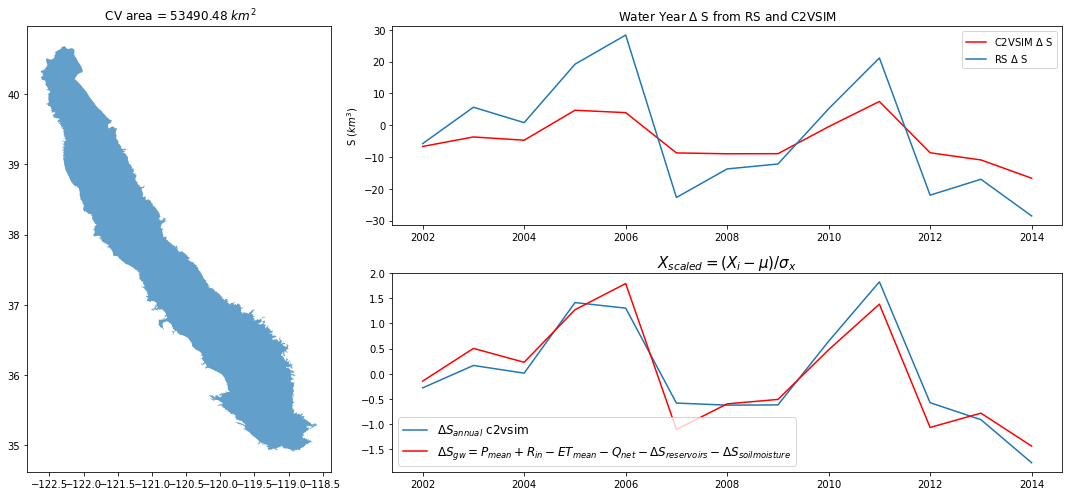

In [72]:
# Plot

plt.figure(figsize=(15, 7))

G = gridspec.GridSpec(2, 3)

# Plot the basemaps
axes_1 = plt.subplot(G[:, 0])
cv.plot(ax=axes_1, alpha = 0.7)
axes_1.set_title(" CV area = {} $km^2$ ".format(sa_km3))

axes_2 = plt.subplot(G[0, 1:])

axes_2.set_title("Water Year $\Delta$ S from RS and C2VSIM")
axes_2.plot(ds_df.index,ds_df.c2vds, color = "red", label = "C2VSIM $\Delta$ S")
axes_2.plot(ds_df.index,ds_df.ds, label = "RS $\Delta$ S")
axes_2.set_ylabel("S $(km^3)$")
axes_2.legend()

axes_3 = plt.subplot(G[1, 1:])
axes_3.set_title("$ X_{scaled} = ({X_i - \mu})/{\sigma_x}$", size = 15)
axes_3.plot(ds_df.index, scaled[1], label = "$\Delta S_{annual}$ c2vsim")
axes_3.plot(ds_df.index, scaled[0], color = "red", label = "$\Delta S_{gw} = P_{mean} + R_{in} -  ET_{mean} - Q_{net} - \Delta S_{reservoirs} - \Delta S_{soil moisture}$")
axes_3.legend(loc="lower left", fontsize = 'large')

plt.tight_layout()
plt.show()

In [625]:
# Run an ensemble varying the ET data used

In [62]:
et_results = []

for i in [endf.modis, endf.gmet_eto, endf.gmet_etr, endf.fldas, endf.terraclimate, endf.et_mean]:
    ds = endf.p_mean - i - endf.q_out + endf.q_in + endf.runoff - endf.soil_moisture.diff() - endf.res_s.diff()

    ds[0] = 0
    et_results.append(ds)
    
results = pd.concat(et_results, axis = 1)
results['avg'] = results.mean(axis = 1)
results['avg'][0] = 0

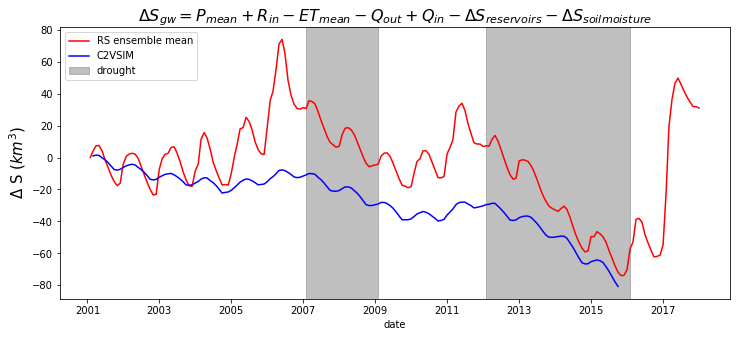

In [66]:
plt.figure(figsize = (12,5))
plt.title("$\Delta S_{gw} = P_{mean} + R_{in} - ET_{mean} - Q_{out} + Q_{in} - \Delta S_{reservoirs} - \Delta S_{soil moisture}$", size = 16)

plt.plot(results.index, np.cumsum(results.avg), color="red", label = "RS ensemble mean")
plt.plot(df.index[1:], np.cumsum(df.s.diff()[1:]), color="blue", label = "C2VSIM")
plt.axvspan(results.index[72], results.index[96], alpha=0.5, color='gray', label = "drought")
plt.axvspan(results.index[132], results.index[180], alpha=0.5, color='gray')
plt.ylabel('$\Delta$ S ($km^3$)', size = 15) 
plt.xlabel('date')
plt.legend()
plt.show()

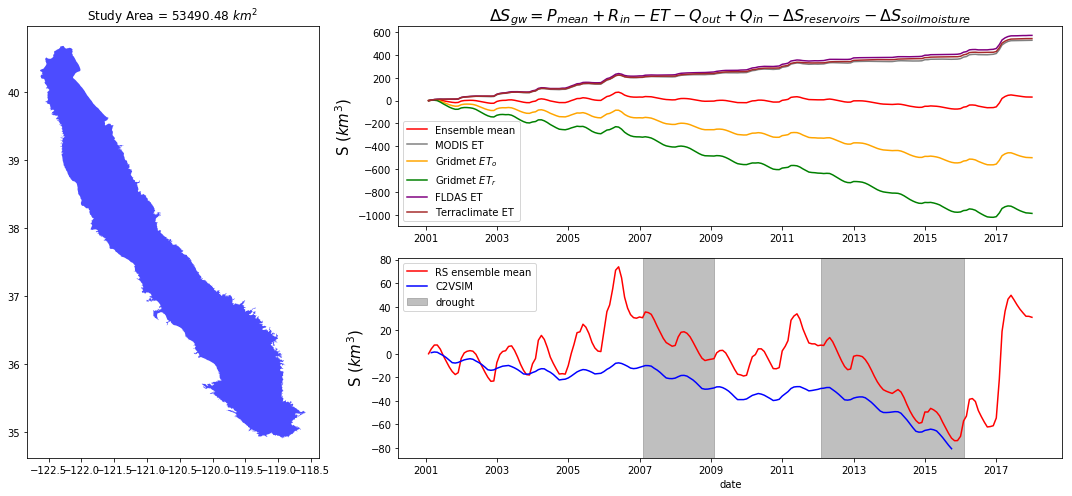

In [67]:
plt.figure(figsize=(15, 7))

G = gridspec.GridSpec(2, 3)

# Plot the basemaps
axes_1 = plt.subplot(G[:, 0])
cv.plot(ax=axes_1, color = "blue", alpha = 0.7)
axes_1.set_title("Study Area = {} $km^2$".format(sa_km3))

a0 = plt.subplot(G[0, 1:])
a0.set_title("$\Delta S_{gw} = P_{mean} + R_{in} - ET - Q_{out} + Q_{in} - \Delta S_{reservoirs} - \Delta S_{soil moisture}$", size = 16)
a0.plot(results.index, np.cumsum(results.avg), color = "red", label = "Ensemble mean")
a0.plot(results.index, np.cumsum(results[0]), color = "gray", label = "MODIS ET")
a0.plot(results.index, np.cumsum(results[1]), color = "orange", label = "Gridmet $ET_o$")
a0.plot(results.index, np.cumsum(results[2]), color = "green", label = "Gridmet $ET_r$")
a0.plot(results.index, np.cumsum(results[3]), color  = "purple", label = "FLDAS ET")
a0.plot(results.index, np.cumsum(results[4]), color = "brown", label = "Terraclimate ET")
a0.set_ylabel('S ($km^3$)', size = 15) 
a0.legend()

axes_4 = plt.subplot(G[1, 1:])
axes_4.plot(results.index, np.cumsum(results.avg), color="red", label = "RS ensemble mean")
axes_4.plot(df.index[1:], np.cumsum(df.s.diff()[1:]), color="blue", label = "C2VSIM")
axes_4.axvspan(results.index[72], results.index[96], alpha=0.5, color='gray', label = "drought")
axes_4.axvspan(results.index[132], results.index[180], alpha=0.5, color='gray')
axes_4.set_ylabel('S ($km^3$)', size = 15) 
axes_4.set_xlabel('date')
axes_4.legend()

plt.tight_layout()
plt.show()